In [13]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import os
import pandas as pd
import numpy as np

import mne
from mne.minimum_norm import apply_inverse, make_inverse_operator
from mne.decoding import GeneralizingEstimator

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering

from scipy.stats import spearmanr

import multiprocess as mp
import dill
# Required for multiprocess to work in Jupyter notebook
dill.settings['recurse'] = True

from functools import partial

In [14]:
def get_perf_timecourse(X, y, decoder, perf_metric, n_splits=5):
    classifying = len(np.unique(y)) <= 2

    n_times = X.shape[-1]

    scores = np.zeros(n_times)
    pvalues = np.zeros(n_times)

    kf = KFold(n_splits, shuffle=True)

    if classifying:
        kf = StratifiedKFold(n_splits, shuffle=True)

    max_acc = 0

    for t in range(n_times):
        t_scores = []
        t_pvalues = []

        for train_indices, test_indices in kf.split(X, y):
            decoder = decoder.fit(X[train_indices, :, t], y[train_indices])
            y_pred = decoder.predict(X[test_indices, :, t])

            if len(np.unique(y_pred)) > 1:
                score = perf_metric(y_pred, y[test_indices])
                acc = decoder.score(X[train_indices, :, t], y[train_indices])

                # if acc > max_acc:
                #     max_acc = acc
                #     print(acc)

                if classifying:
                    t_scores.append(score)
                    t_pvalues.append(0)
                else:
                    t_scores.append(score.statistic)
                    t_pvalues.append(score.pvalue)

        scores[t] = sum(t_scores) / len(t_scores)
        pvalues[t] = max(t_pvalues)

    return scores, pvalues


In [15]:
def as_df(x, y):
    return pd.DataFrame({'x': x, 'y': y})

In [16]:
def get_data(filename):
    fif = mne.read_epochs(f"./sub_data/{filename}")
    
    metadata = fif.metadata
    stim_features = metadata[["freq", "condition", "trial_type"]].to_numpy()

    sub_data = fif.get_data(picks=["meg"])
    
    del fif

    return stim_features, sub_data

In [17]:
# Useful constants for the rest of the code
sub_files = os.listdir("./sub_data")
n_subs = len(sub_files)

_, initial_sub_data = get_data(sub_files[0])
tpoints = initial_sub_data.shape[-1]

# Recordings were -200ms to 600ms, relative to the tone being played, collected at 161 points
t = np.linspace(-200, 600, tpoints)

# Helper function to get first index where condition is true
def index_of(cond):
    indices = np.where(cond)[0]
    
    if len(indices) == 0:
        return -1
    else:
        return indices[0]

# Helper for finding index of a particular point in time
def at_t(t_point):
    return index_of(t == t_point)

Reading C:\Users\isaac\Code\surp\sub_data\A0216_shepard-epo-lp20.fif ...


C:\Users\isaac\AppData\Local\Temp\ipykernel_23412\512867986.py:2: RuntimeWarning: This filename (./sub_data/A0216_shepard-epo-lp20.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  fif = mne.read_epochs(f"./sub_data/{filename}")


    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Adding metadata with 17 columns
7645 matching events found
No baseline correction applied
0 projection items activated


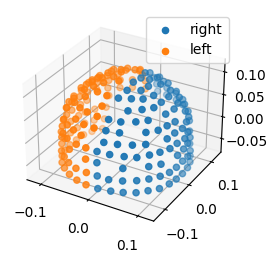

In [38]:
fig = plt.figure()
ax3d = fig.add_subplot(122, projection="3d")

n_meg = 208
sensor_locations = np.zeros((n_meg, 3))

for i, ch in enumerate(fif.info["chs"]):
    if i < 208:
        sensor_locations[i] = ch['loc'][:3]

right_idx = sensor_locations[:,0] >= 0
right_sensors = sensor_locations[right_idx]

left_idx = sensor_locations[:,0] <= 0
left_sensors = sensor_locations[left_idx]

ax3d.scatter(*right_sensors.T, label="right")
ax3d.scatter(*left_sensors.T, label="left")
ax3d.legend()

In [39]:
filters = {
    "pure": lambda features: (features[:,1] == "pure"),
    "complex": lambda features: (features[:,1] == "partial"),
    "ambiguous": lambda features: (features[:,1] == "shepard")
}

MERGED_SCORES_LOCATION = {"right": "merged_scores_right.npy", "left": "merged_scores_left.npy"}

channel_subsets = {"right": right_idx, "left": left_idx}

def get_sub_scores(filename, side):    
    stim_features, sub_data = get_data(filename)
    
    ridge_decoder = make_pipeline(
        StandardScaler(),
        Ridge()
    )
    
    freqs = stim_features[:, 0]

    sub_scores = { }
    
    for condition in filters:
        condition_filter = filters[condition](stim_features)

        print(f"Finding {condition} scores for {filename}...", end="\r")
        condition_scores, _ = get_perf_timecourse(
            sub_data[condition_filter, channel_subsets[side]], 
            freqs[condition_filter], 
            ridge_decoder, 
            spearmanr
        )
        
        sub_scores[condition] = condition_scores
    
    del freqs, sub_data, stim_features

    return sub_scores

def save_merged_scores(merged_scores, side):
    np.save(MERGED_SCORES_LOCATION, merged_scores)

def load_merged_scores(side):
    empty = not os.path.isfile(MERGED_SCORES_LOCATION[side])
    merged_sub_scores = {
        "pure": np.zeros((n_subs, tpoints)),
        "complex": np.zeros((n_subs, tpoints)),
        "ambiguous": np.zeros((n_subs, tpoints)),
    }
    
    if not empty:
        try:
            merged_sub_scores = np.load("merged_scores.npy", allow_pickle=True).item()
        except Exception:
            empty = True
            return merged_sub_scores, empty
    
    return merged_sub_scores, empty

In [40]:
merged_sub_scores = {"left": None, "right": None}

for side in ["left", "right"]:
    side_scores, empty = load_merged_scores(side)

    # If merged scores have not already been saved, generate them (this takes a long time)
    if empty:
        output = None

        try:
            pool = mp.Pool(4)
            output = pool.map(partial(get_sub_scores, side=side), sub_files)
        except KeyboardInterrupt as e:
            pass
        finally:
            pool.terminate()
            pool.join()

        side_scores = {
            "pure": np.zeros((n_subs, tpoints)),
            "complex": np.zeros((n_subs, tpoints)),
            "ambiguous": np.zeros((n_subs, tpoints)),
        }

        for i in range(n_subs):
            for condition in filters:
                side_scores[condition][i] = output[i][condition]

        save_merged_scores(side_scores, side)
        
        merged_sub_scores[side] = side_scores

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (2160,) (105,) 